In [2]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [3]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [4]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [5]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [7]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [8]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [9]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [10]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=20, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [11]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [12]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 19s 793ms/step - loss: 0.5603 - acc: 0.6978 - val_loss: 0.3450 - val_acc: 0.8827
Epoch 2/100
24/24 [==============================] - 14s 578ms/step - loss: 0.3682 - acc: 0.8318 - val_loss: 0.3018 - val_acc: 0.8642
Epoch 3/100
24/24 [==============================] - 14s 579ms/step - loss: 0.3193 - acc: 0.8614 - val_loss: 0.2353 - val_acc: 0.8889
Epoch 4/100
24/24 [==============================] - 12s 503ms/step - loss: 0.2852 - acc: 0.8707 - val_loss: 0.2888 - val_acc: 0.8704
Epoch 5/100
24/24 [==============================] - 14s 587ms/step - loss: 0.2632 - acc: 0.8883 - val_loss: 0.2016 - val_acc: 0.9198
Epoch 6/100
24/24 [==============================] - 12s 508ms/step - loss: 0.2419 - acc: 0.9045 - val_loss: 0.2245 - val_acc: 0.9074
Epoch 7/100
24/24 [==============================] - 12s 509ms/step - loss: 0.2388 - acc: 0.8933 - val_loss: 0.2120 - val_acc: 0.9136
Epoch 8/100
24/24 [===============

Epoch 41/100
24/24 [==============================] - 12s 504ms/step - loss: 0.1221 - acc: 0.9552 - val_loss: 0.2227 - val_acc: 0.9068
Epoch 42/100
24/24 [==============================] - 12s 503ms/step - loss: 0.0976 - acc: 0.9622 - val_loss: 0.2076 - val_acc: 0.9255
Epoch 43/100
24/24 [==============================] - 12s 507ms/step - loss: 0.1294 - acc: 0.9454 - val_loss: 0.2265 - val_acc: 0.9130
Epoch 44/100
24/24 [==============================] - 12s 502ms/step - loss: 0.1280 - acc: 0.9475 - val_loss: 0.1932 - val_acc: 0.9068
Epoch 45/100
24/24 [==============================] - 12s 503ms/step - loss: 0.1312 - acc: 0.9498 - val_loss: 0.1708 - val_acc: 0.9130
Epoch 46/100
24/24 [==============================] - 12s 497ms/step - loss: 0.1098 - acc: 0.9545 - val_loss: 0.2774 - val_acc: 0.9006
Train loss: 0.0945974818882
Train accuracy: 0.968814968815
Test loss: 0.148577949275
Test accuracy: 0.931677018634

===================FOLD= 3
Epoch 1/100
24/24 [============================

Epoch 5/100
24/24 [==============================] - 14s 587ms/step - loss: 0.4387 - acc: 0.8122 - val_loss: 0.2514 - val_acc: 0.9062
Epoch 6/100
24/24 [==============================] - 14s 588ms/step - loss: 0.3755 - acc: 0.8285 - val_loss: 0.2452 - val_acc: 0.8938
Epoch 7/100
24/24 [==============================] - 12s 505ms/step - loss: 0.4112 - acc: 0.7990 - val_loss: 0.2615 - val_acc: 0.8875
Epoch 8/100
24/24 [==============================] - 14s 588ms/step - loss: 0.3165 - acc: 0.8404 - val_loss: 0.1950 - val_acc: 0.9500
Epoch 9/100
24/24 [==============================] - 14s 585ms/step - loss: 0.2860 - acc: 0.8798 - val_loss: 0.1680 - val_acc: 0.9563
Epoch 10/100
24/24 [==============================] - 12s 506ms/step - loss: 0.2948 - acc: 0.8650 - val_loss: 0.1744 - val_acc: 0.9500
Epoch 11/100
24/24 [==============================] - 12s 509ms/step - loss: 0.2896 - acc: 0.8692 - val_loss: 0.2166 - val_acc: 0.9313
Epoch 12/100
24/24 [==============================] - 12s 50

Epoch 25/100
24/24 [==============================] - 12s 506ms/step - loss: 0.1782 - acc: 0.9287 - val_loss: 0.2267 - val_acc: 0.9313
Epoch 26/100
24/24 [==============================] - 12s 504ms/step - loss: 0.1979 - acc: 0.9200 - val_loss: 0.1775 - val_acc: 0.9437
Epoch 27/100
24/24 [==============================] - 12s 505ms/step - loss: 0.1591 - acc: 0.9371 - val_loss: 0.1895 - val_acc: 0.9250
Epoch 28/100
24/24 [==============================] - 12s 503ms/step - loss: 0.1435 - acc: 0.9381 - val_loss: 0.1784 - val_acc: 0.9313
Epoch 29/100
24/24 [==============================] - 12s 503ms/step - loss: 0.1511 - acc: 0.9366 - val_loss: 0.2283 - val_acc: 0.9500
Epoch 30/100
24/24 [==============================] - 12s 509ms/step - loss: 0.1839 - acc: 0.9200 - val_loss: 0.2716 - val_acc: 0.9313
Epoch 31/100
24/24 [==============================] - 12s 504ms/step - loss: 0.1433 - acc: 0.9384 - val_loss: 0.2086 - val_acc: 0.9437
Epoch 32/100
24/24 [==============================] - 1

Epoch 42/100
24/24 [==============================] - 12s 503ms/step - loss: 0.1253 - acc: 0.9484 - val_loss: 0.3196 - val_acc: 0.8625
Epoch 43/100
24/24 [==============================] - 12s 502ms/step - loss: 0.1576 - acc: 0.9378 - val_loss: 0.2662 - val_acc: 0.8688
Epoch 44/100
24/24 [==============================] - 12s 504ms/step - loss: 0.1087 - acc: 0.9533 - val_loss: 0.2720 - val_acc: 0.8750
Epoch 45/100
24/24 [==============================] - 12s 503ms/step - loss: 0.1112 - acc: 0.9577 - val_loss: 0.2997 - val_acc: 0.9000
Epoch 46/100
24/24 [==============================] - 12s 496ms/step - loss: 0.1150 - acc: 0.9609 - val_loss: 0.2338 - val_acc: 0.9313
Epoch 47/100
24/24 [==============================] - 12s 504ms/step - loss: 0.0964 - acc: 0.9603 - val_loss: 0.2914 - val_acc: 0.8688
Epoch 48/100
24/24 [==============================] - 12s 502ms/step - loss: 0.1136 - acc: 0.9487 - val_loss: 0.2889 - val_acc: 0.9125
Epoch 49/100
24/24 [==============================] - 1

Epoch 31/100
24/24 [==============================] - 12s 506ms/step - loss: 0.1367 - acc: 0.9451 - val_loss: 0.1912 - val_acc: 0.9250
Epoch 32/100
24/24 [==============================] - 12s 508ms/step - loss: 0.1394 - acc: 0.9441 - val_loss: 0.1825 - val_acc: 0.9187
Epoch 33/100
24/24 [==============================] - 12s 510ms/step - loss: 0.1426 - acc: 0.9384 - val_loss: 0.1951 - val_acc: 0.9000
Epoch 34/100
24/24 [==============================] - 12s 505ms/step - loss: 0.1342 - acc: 0.9425 - val_loss: 0.2236 - val_acc: 0.9125
Epoch 35/100
24/24 [==============================] - 12s 506ms/step - loss: 0.1262 - acc: 0.9441 - val_loss: 0.2160 - val_acc: 0.9125
Epoch 36/100
24/24 [==============================] - 12s 510ms/step - loss: 0.1288 - acc: 0.9487 - val_loss: 0.2162 - val_acc: 0.9125
Epoch 37/100
24/24 [==============================] - 12s 503ms/step - loss: 0.1105 - acc: 0.9572 - val_loss: 0.2429 - val_acc: 0.8875
Epoch 38/100
24/24 [==============================] - 1

Epoch 31/100
24/24 [==============================] - 12s 510ms/step - loss: 0.1381 - acc: 0.9461 - val_loss: 0.3192 - val_acc: 0.8625
Epoch 32/100
24/24 [==============================] - 12s 504ms/step - loss: 0.1299 - acc: 0.9510 - val_loss: 0.5354 - val_acc: 0.8625
Train loss: 0.138392210832
Train accuracy: 0.941135734072
Test loss: 0.303934437037
Test accuracy: 0.86875

===================FOLD= 9
Epoch 1/100
24/24 [==============================] - 18s 736ms/step - loss: 0.8947 - acc: 0.5891 - val_loss: 0.5356 - val_acc: 0.7562
Epoch 2/100
24/24 [==============================] - 14s 591ms/step - loss: 0.4851 - acc: 0.7844 - val_loss: 0.4580 - val_acc: 0.7562
Epoch 3/100
24/24 [==============================] - 12s 509ms/step - loss: 0.4390 - acc: 0.8011 - val_loss: 0.4836 - val_acc: 0.8187
Epoch 4/100
24/24 [==============================] - 14s 589ms/step - loss: 0.3888 - acc: 0.8329 - val_loss: 0.2584 - val_acc: 0.8812
Epoch 5/100
24/24 [==============================] - 14s 59

In [13]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [14]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_10folds_amsgrad_0001_20p.csv', index=False)

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


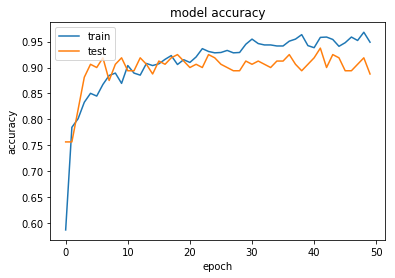

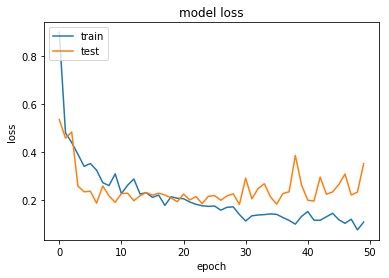

In [15]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [16]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [17]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

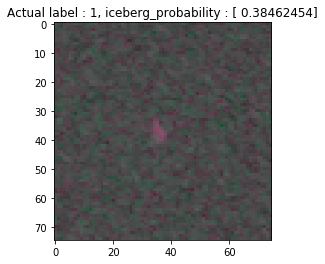

In [18]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

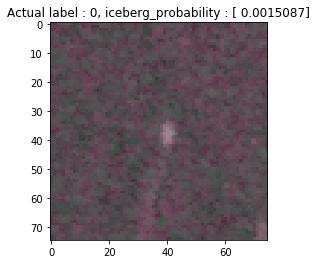

In [19]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

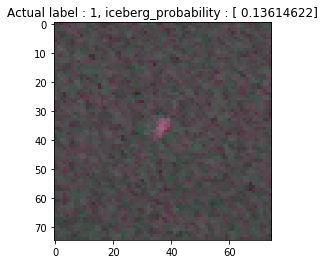

In [20]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

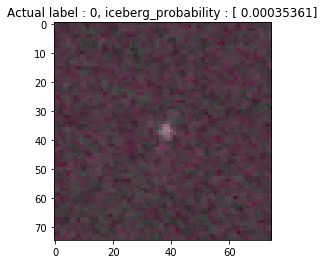

In [21]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

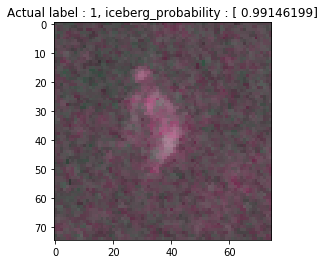

In [22]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

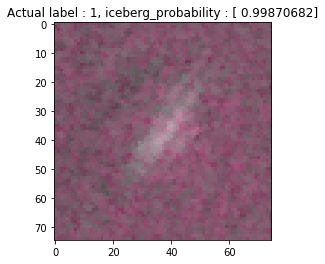

In [23]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)

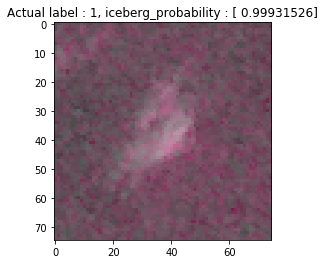

In [24]:
plt.imshow(X_holdout2[10], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[141])+ ","+" iceberg_probability : "+str(pred_valid[10])
plt.title(tl)

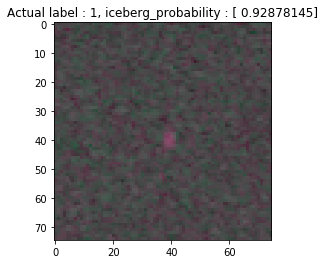

In [25]:
plt.imshow(X_holdout2[11], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[167])+ ","+" iceberg_probability : "+str(pred_valid[11])
plt.title(tl)

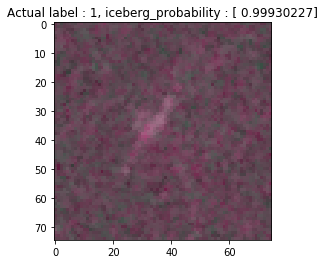

In [26]:
plt.imshow(X_holdout2[12], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[195])+ ","+" iceberg_probability : "+str(pred_valid[12])
plt.title(tl)

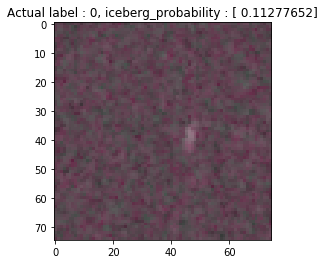

In [27]:
plt.imshow(X_holdout2[13], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[199])+ ","+" iceberg_probability : "+str(pred_valid[13])
plt.title(tl)